# Fase 4: Score de Risco Contínuo

Nesta fase, vamos calcular um score de risco contínuo (0-100) usando o modelo Isolation Forest já treinado na Fase 3. Este score fornece uma medida granular do nível de risco de cada transação, permitindo priorização e tomada de decisão mais refinada.

In [1]:
# Importação de bibliotecas essenciais
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

# Configurações para visualização
sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (15, 8)
plt.rcParams['font.size'] = 12

print("✅ Bibliotecas importadas com sucesso!")

✅ Bibliotecas importadas com sucesso!


## Carregando Dados Processados

In [2]:
# Carregar os dados processados da Fase 2
X_processed = np.load('../data/processed/X_processed.npy')

# Carregar o scaler
with open('../data/processed/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Carregar nomes das features
with open('../data/processed/feature_names.pkl', 'rb') as f:
    feature_names = pickle.load(f)

print(f"✅ Dados carregados de: ../data/processed/")
print(f"✅ Shape dos dados: {X_processed.shape}")
print(f"✅ Features disponíveis: {len(feature_names)}")

✅ Dados carregados de: ../data/processed/
✅ Shape dos dados: (2512, 15)
✅ Features disponíveis: 15


## Calculando Score de Risco Contínuo

## Carregando Modelo Treinado da Fase 3

Vamos carregar o modelo Isolation Forest já treinado na fase anterior para calcular o score de risco contínuo.

In [3]:
# Carregando o modelo Isolation Forest já treinado da Fase 3
import joblib

try:
    iso_forest = joblib.load('../models/isolation_forest_model.pkl')
    print("✅ Modelo carregado com sucesso de: ../models/isolation_forest_model.pkl")
    print(f"   Parâmetros: contamination={iso_forest.contamination}, n_estimators={iso_forest.n_estimators}")
except FileNotFoundError:
    print("❌ Modelo não encontrado em ../models/isolation_forest_model.pkl")
    print("💡 Execute primeiro a Fase 3 para treinar e salvar o modelo.")
    raise

✅ Modelo carregado com sucesso de: ../models/isolation_forest_model.pkl
   Parâmetros: contamination=0.02, n_estimators=100


In [4]:
# Obtendo predições e scores de risco do modelo carregado
predictions = iso_forest.predict(X_processed)
print(f"Predições obtidas: {len(predictions)}")
print(f"Anomalias detectadas: {np.sum(predictions == -1)}")
print(f"Transações normais: {np.sum(predictions == 1)}")

# Calculando o score de risco contínuo
# decision_function retorna valores negativos para anomalias e positivos para normais
# Quanto mais negativo, mais anômala é a transação
anomaly_scores = iso_forest.decision_function(X_processed)

print("\n--- SCORES DE RISCO BRUTO ---")
print(f"Score mínimo (mais anômalo): {anomaly_scores.min():.4f}")
print(f"Score máximo (mais normal): {anomaly_scores.max():.4f}")
print(f"Score médio: {anomaly_scores.mean():.4f}")

# Convertendo para um score de risco de 0 a 100 (mais intuitivo)
# 0 = muito normal, 100 = muito anômalo
# Normalizamos os scores e invertemos a escala
min_score = anomaly_scores.min()
max_score = anomaly_scores.max()
risk_scores = 100 * (max_score - anomaly_scores) / (max_score - min_score)

print(f"\n--- SCORES DE RISCO (0-100) ---")
print(f"Score de risco mínimo: {risk_scores.min():.2f}")
print(f"Score de risco máximo: {risk_scores.max():.2f}")
print(f"Score de risco médio: {risk_scores.mean():.2f}")

print("\n--- DISTRIBUIÇÃO DOS SCORES DE RISCO ---")
print("Percentis dos scores de risco:")
for percentile in [10, 25, 50, 75, 90, 95, 99]:
    score = np.percentile(risk_scores, percentile)
    print(f"P{percentile}: {score:.2f}")

Predições obtidas: 2512
Anomalias detectadas: 51
Transações normais: 2461

--- SCORES DE RISCO BRUTO ---
Score mínimo (mais anômalo): -0.0743
Score máximo (mais normal): 0.1755
Score médio: 0.0890

--- SCORES DE RISCO (0-100) ---
Score de risco mínimo: 0.00
Score de risco máximo: 100.00
Score de risco médio: 34.64

--- DISTRIBUIÇÃO DOS SCORES DE RISCO ---
Percentis dos scores de risco:
P10: 16.88
P25: 23.69
P50: 33.18
P75: 44.12
P90: 54.48
P95: 61.16
P99: 74.55


## Criando DataFrame com Scores

In [5]:
# Criando DataFrame com os dados processados e scores
df_processed = pd.DataFrame(X_processed, columns=feature_names)
df_processed['anomaly_score'] = predictions
df_processed['anomaly_score_raw'] = anomaly_scores
df_processed['risk_score'] = risk_scores

# Analisando as transações com maior score de risco
print("--- TOP 10 TRANSAÇÕES MAIS ARRISCADAS ---")
top_risky = df_processed.nlargest(10, 'risk_score')[['risk_score', 'anomaly_score_raw', 'anomaly_score']]
display(top_risky)

--- TOP 10 TRANSAÇÕES MAIS ARRISCADAS ---


,risk_score,anomaly_score_raw,anomaly_score
274,100.000000,-0.074314,-1
614,94.234339,-0.059909,-1
1459,93.442429,-0.057931,-1
1213,92.571088,-0.055754,-1
394,91.247100,-0.052446,-1
934,86.609623,-0.040860,-1
898,84.948258,-0.036709,-1
2191,84.185900,-0.034804,-1
1703,81.796262,-0.028834,-1
1057,81.082998,-0.027052,-1


## Categorização por Faixas de Risco

In [6]:
# Definindo faixas de risco
risk_bins = [0, 25, 50, 75, 90, 100]
risk_labels = ['Muito Baixo', 'Baixo', 'Médio', 'Alto', 'Muito Alto']
df_processed['risk_category'] = pd.cut(risk_scores, bins=risk_bins, labels=risk_labels)

# Contagem por categoria
risk_counts = df_processed['risk_category'].value_counts()

print("--- ANÁLISE POR FAIXAS DE RISCO ---")
for category in risk_labels:
    count = (df_processed['risk_category'] == category).sum()
    percentage = (count / len(df_processed)) * 100
    print(f"{category}: {count} transações ({percentage:.2f}%)")

print("\n--- CLASSIFICAÇÃO DE RISCO ---")
print("Score 0-25: Risco Muito Baixo - Transações normais")
print("Score 25-50: Risco Baixo - Ligeiramente suspeitas")  
print("Score 50-75: Risco Médio - Moderadamente suspeitas")
print("Score 75-90: Risco Alto - Altamente suspeitas")
print("Score 90-100: Risco Muito Alto - Extremamente suspeitas (prováveis fraudes)")

--- ANÁLISE POR FAIXAS DE RISCO ---
Muito Baixo: 720 transações (28.66%)
Baixo: 1409 transações (56.09%)
Médio: 357 transações (14.21%)
Alto: 20 transações (0.80%)
Muito Alto: 5 transações (0.20%)

--- CLASSIFICAÇÃO DE RISCO ---
Score 0-25: Risco Muito Baixo - Transações normais
Score 25-50: Risco Baixo - Ligeiramente suspeitas
Score 50-75: Risco Médio - Moderadamente suspeitas
Score 75-90: Risco Alto - Altamente suspeitas
Score 90-100: Risco Muito Alto - Extremamente suspeitas (prováveis fraudes)


## Análise das Features Mais Discriminativas

In [7]:
# Analisando diferenças entre anomalias e transações normais
anomalies_processed = df_processed[df_processed['anomaly_score'] == -1]
normals_processed = df_processed[df_processed['anomaly_score'] == 1]

features_for_analysis = [col for col in feature_names if col not in ['anomaly_score', 'anomaly_score_raw', 'risk_score']]

anomaly_means = anomalies_processed[features_for_analysis].mean()
normal_means = normals_processed[features_for_analysis].mean()
differences = anomaly_means - normal_means

# Ordenando as diferenças para identificar as features mais discriminativas
differences_sorted = differences.abs().sort_values(ascending=False)

print("--- FEATURES MAIS DISCRIMINATIVAS ---")
print("(Ordenadas por diferença absoluta nas médias)")
for i, feature in enumerate(differences_sorted.index[:10], 1):
    diff = differences[feature]
    direction = "(anomalias maior)" if diff > 0 else "(normais maior)"
    print(f"{i:2d}. {feature}: {diff:.3f} {direction}")

--- FEATURES MAIS DISCRIMINATIVAS ---
(Ordenadas por diferença absoluta nas médias)
 1. AmountToBalanceRatio: 2.550 (anomalias maior)
 2. LoginAttempts: 2.347 (anomalias maior)
 3. TransactionAmount: 1.552 (anomalias maior)
 4. TransactionType_Debit: -1.075 (normais maior)
 5. DayOfWeek: 0.624 (anomalias maior)
 6. AccountBalance: -0.449 (normais maior)
 7. TransactionDuration: 0.415 (anomalias maior)
 8. Channel_Online: 0.323 (anomalias maior)
 9. TransactionHour: 0.276 (anomalias maior)
10. Channel_Branch: 0.268 (anomalias maior)


## Visualizações do Score de Risco

✅ Gráfico salvo em: ../results/plots/score_risco_visualizacoes.png


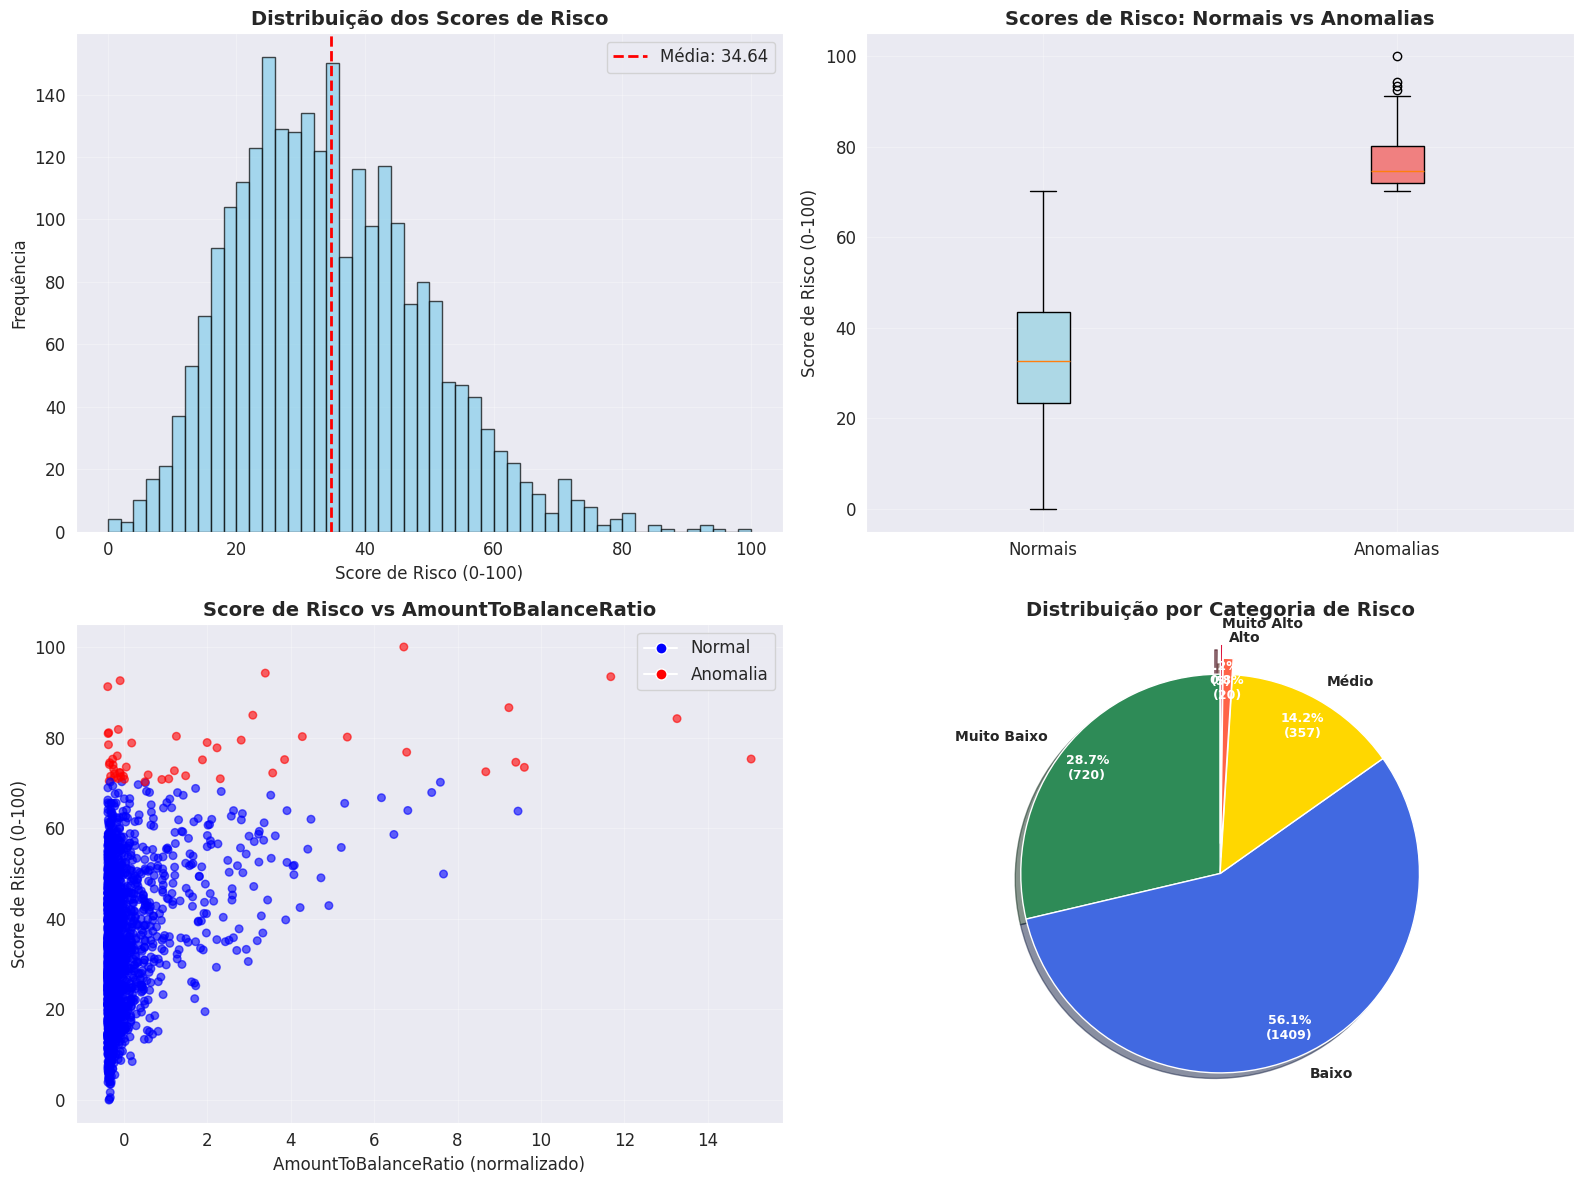


--- RESUMO DA DISTRIBUIÇÃO DE RISCO ---
Muito Baixo :  720 transações ( 28.7%)
Baixo       : 1409 transações ( 56.1%)
Médio       :  357 transações ( 14.2%)
Alto        :   20 transações (  0.8%)
Muito Alto  :    5 transações (  0.2%)


In [8]:
# Criando diretórios organizados
plots_dir = '../results/plots'
os.makedirs(plots_dir, exist_ok=True)

# Criando visualizações dos scores de risco
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Histograma dos scores de risco
axes[0, 0].hist(risk_scores, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribuição dos Scores de Risco', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Score de Risco (0-100)')
axes[0, 0].set_ylabel('Frequência')
axes[0, 0].axvline(risk_scores.mean(), color='red', linestyle='--', linewidth=2, 
                   label=f'Média: {risk_scores.mean():.2f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Boxplot comparando scores de normais vs anomalias (corrigido warning)
risk_data = [risk_scores[predictions == 1], risk_scores[predictions == -1]]
tick_labels = ['Normais', 'Anomalias']
bp = axes[0, 1].boxplot(risk_data, tick_labels=tick_labels, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][1].set_facecolor('lightcoral')
axes[0, 1].set_title('Scores de Risco: Normais vs Anomalias', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Score de Risco (0-100)')
axes[0, 1].grid(True, alpha=0.3)

# 3. Scatter plot: Score de risco vs feature mais discriminativa
top_feature = differences_sorted.index[0]
colors = ['red' if pred == -1 else 'blue' for pred in predictions]
axes[1, 0].scatter(df_processed[top_feature], risk_scores, alpha=0.6, c=colors, s=30)
axes[1, 0].set_title(f'Score de Risco vs {top_feature}', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel(f'{top_feature} (normalizado)')
axes[1, 0].set_ylabel('Score de Risco (0-100)')
axes[1, 0].grid(True, alpha=0.3)

# Legenda para scatter plot
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label='Normal'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label='Anomalia')]
axes[1, 0].legend(handles=legend_elements)

# 4. Gráfico de pizza CORRIGIDO (sem sobreposição)
risk_counts_ordered = risk_counts.reindex(risk_labels, fill_value=0)

# Filtrar categorias com valores zero para evitar problemas
non_zero_counts = risk_counts_ordered[risk_counts_ordered > 0]
non_zero_labels = non_zero_counts.index.tolist()

# Cores correspondentes apenas para categorias não-zero
color_map = {
    'Muito Baixo': '#2E8B57',    # Verde escuro
    'Baixo': '#4169E1',          # Azul
    'Médio': '#FFD700',          # Amarelo/Dourado
    'Alto': '#FF6347',           # Laranja/Vermelho
    'Muito Alto': '#DC143C'      # Vermelho escuro
}
selected_colors = [color_map[label] for label in non_zero_labels]

# Criar gráfico de pizza melhorado
if len(non_zero_counts) > 0:
    # Calcular explode baseado no risco (maiores riscos mais destacados)
    explode_values = []
    for label in non_zero_labels:
        if label == 'Muito Alto':
            explode_values.append(0.15)
        elif label == 'Alto':
            explode_values.append(0.08)
        else:
            explode_values.append(0)
    
    wedges, texts, autotexts = axes[1, 1].pie(
        non_zero_counts.values,
        labels=non_zero_labels,
        autopct=lambda pct: f'{pct:.1f}%\n({int(pct/100*len(df_processed))})',
        colors=selected_colors,
        startangle=90,
        explode=explode_values,
        shadow=True,
        textprops={'fontsize': 9, 'fontweight': 'bold'},
        pctdistance=0.85  # Distância dos percentuais do centro
    )
    
    # Melhorar legibilidade dos textos
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(9)
    
    # Ajustar posição dos labels para evitar sobreposição
    for text in texts:
        text.set_fontsize(10)
        text.set_fontweight('bold')

axes[1, 1].set_title('Distribuição por Categoria de Risco', fontsize=14, fontweight='bold')

plt.tight_layout()

# Salvar o gráfico
plot_path = f'{plots_dir}/score_risco_visualizacoes.png'
plt.savefig(plot_path, dpi=300, bbox_inches='tight')
print(f"✅ Gráfico salvo em: {plot_path}")

plt.show()

# Resumo estatístico da distribuição
print("\n--- RESUMO DA DISTRIBUIÇÃO DE RISCO ---")
total = len(df_processed)
for category in risk_labels:
    count = (df_processed['risk_category'] == category).sum()
    percentage = (count / total) * 100
    if count > 0:
        print(f"{category:12}: {count:4d} transações ({percentage:5.1f}%)")
    else:
        print(f"{category:12}: {count:4d} transações ({percentage:5.1f}%) - Não exibido no gráfico")

## Análise Detalhada por Score de Risco

In [9]:
# Análise mais detalhada dos scores altos
print("--- ANÁLISE DETALHADA POR FAIXAS DE RISCO ---")

# Definindo faixas mais granulares para análise
detailed_bins = [0, 10, 25, 50, 75, 85, 95, 100]
detailed_labels = ['0-10', '10-25', '25-50', '50-75', '75-85', '85-95', '95-100']
df_processed['detailed_risk'] = pd.cut(risk_scores, bins=detailed_bins, labels=detailed_labels)

detailed_counts = df_processed['detailed_risk'].value_counts().sort_index()

for category in detailed_labels:
    count = (df_processed['detailed_risk'] == category).sum()
    percentage = (count / len(df_processed)) * 100
    print(f"Score {category}: {count} transações ({percentage:.2f}%)")

# Foco nas transações de alto risco
high_risk = df_processed[df_processed['risk_score'] >= 75]
very_high_risk = df_processed[df_processed['risk_score'] >= 90]

print(f"\n--- TRANSAÇÕES DE ALTO RISCO (≥75) ---")
print(f"Total: {len(high_risk)} transações ({len(high_risk)/len(df_processed)*100:.2f}%)")

print(f"\n--- TRANSAÇÕES DE RISCO MUITO ALTO (≥90) ---")
print(f"Total: {len(very_high_risk)} transações ({len(very_high_risk)/len(df_processed)*100:.2f}%)")

if len(very_high_risk) > 0:
    print("\nCaracterísticas das transações de risco muito alto:")
    display(very_high_risk[['risk_score', 'anomaly_score_raw'] + features_for_analysis[:5]].describe())

--- ANÁLISE DETALHADA POR FAIXAS DE RISCO ---
Score 0-10: 54 transações (2.15%)
Score 10-25: 666 transações (26.51%)
Score 25-50: 1409 transações (56.09%)
Score 50-75: 357 transações (14.21%)
Score 75-85: 19 transações (0.76%)
Score 85-95: 5 transações (0.20%)
Score 95-100: 1 transações (0.04%)

--- TRANSAÇÕES DE ALTO RISCO (≥75) ---
Total: 25 transações (1.00%)

--- TRANSAÇÕES DE RISCO MUITO ALTO (≥90) ---
Total: 5 transações (0.20%)

Características das transações de risco muito alto:


,risk_score,anomaly_score_raw,TransactionAmount,CustomerAge,TransactionDuration,LoginAttempts,AccountBalance
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,94.298991,-0.060071,1.979369,0.142003,0.985802,3.776330,-0.458075
std,3.374132,0.008430,1.884826,1.449338,1.017256,3.636077,1.038175
min,91.247100,-0.074314,-0.997964,-1.330846,-0.237932,-0.206794,-1.283905
25%,92.571088,-0.059909,1.240599,-1.330846,0.405386,-0.206794,-1.228310
50%,93.442429,-0.057931,3.010353,0.524269,0.777081,6.431745,-1.133355
75%,94.234339,-0.055754,3.064894,0.861562,1.649135,6.431745,0.662376
max,100.000000,-0.052446,3.578961,1.985874,2.335341,6.431745,0.692818


## Salvando Resultados

In [10]:
# Organizando salvamento em diretórios estruturados
scores_dir = '../results/scores'
results_dir = '../results'
os.makedirs(scores_dir, exist_ok=True)

# Preparando dados para salvar - scores de risco organizados
results_df = df_processed[[
    'risk_score', 'anomaly_score_raw', 'anomaly_score', 
    'risk_category', 'detailed_risk'
]].copy()

# Salvando resultados de scores em results/scores/
scores_csv_path = f'{scores_dir}/risk_scores_detailed.csv'
results_df.to_csv(scores_csv_path, index=True)
print(f"✅ Scores detalhados salvos em: {scores_csv_path}")

# Salvando resumo compacto em results/
summary_csv_path = f'{results_dir}/risk_analysis_summary.csv'
summary_data = {
    'Categoria': risk_labels,
    'Quantidade': [int((df_processed['risk_category'] == cat).sum()) for cat in risk_labels],
    'Porcentagem': [float((df_processed['risk_category'] == cat).sum() / len(df_processed) * 100) for cat in risk_labels]
}
summary_df = pd.DataFrame(summary_data)
summary_df.to_csv(summary_csv_path, index=False)
print(f"✅ Resumo da análise salvo em: {summary_csv_path}")

# Salvando resumo técnico completo em scores/
technical_summary = {
    'analysis_metadata': {
        'analysis_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        'total_transactions': len(df_processed),
        'anomalies_detected': int((predictions == -1).sum()),
        'model_contamination': 0.02
    },
    'risk_score_statistics': {
        'min': float(risk_scores.min()),
        'max': float(risk_scores.max()),
        'mean': float(risk_scores.mean()),
        'std': float(risk_scores.std()),
        'percentiles': {
            f'p{p}': float(np.percentile(risk_scores, p)) 
            for p in [25, 50, 75, 90, 95, 99]
        }
    },
    'risk_distribution': {
        'by_category': {cat: int((df_processed['risk_category'] == cat).sum()) for cat in risk_labels},
        'detailed_distribution': detailed_counts.to_dict()
    },
    'business_impact': {
        'high_risk_transactions': len(high_risk),
        'very_high_risk_transactions': len(very_high_risk),
        'manual_review_percentage': float(len(high_risk) / len(df_processed) * 100),
        'immediate_block_percentage': float(len(very_high_risk) / len(df_processed) * 100)
    },
    'top_discriminative_features': differences_sorted.head(5).to_dict(),
    'file_paths': {
        'detailed_scores': scores_csv_path,
        'summary_analysis': summary_csv_path,
        'visualization': f'{plots_dir}/score_risco_visualizacoes.png'
    }
}

technical_summary_path = f'{scores_dir}/technical_analysis_summary.pkl'
with open(technical_summary_path, 'wb') as f:
    pickle.dump(technical_summary, f)
print(f"✅ Resumo técnico salvo em: {technical_summary_path}")

print(f"\n🎉 Análise de Score de Risco completa e organizada!")
print(f"\n📊 Resumo da análise:")
print(f"   - Total de transações: {len(df_processed)}")
print(f"   - Anomalias detectadas: {len(anomalies_processed)}")
print(f"   - Alto risco (≥75): {len(high_risk)} ({len(high_risk)/len(df_processed)*100:.1f}%)")
print(f"   - Muito alto risco (≥90): {len(very_high_risk)} ({len(very_high_risk)/len(df_processed)*100:.1f}%)")

print(f"\n📁 Arquivos organizados em:")
print(f"   - Scores detalhados: {scores_dir}/")
print(f"   - Resumos: {results_dir}/")
print(f"   - Gráficos: {plots_dir}/")

✅ Scores detalhados salvos em: ../results/scores/risk_scores_detailed.csv
✅ Resumo da análise salvo em: ../results/risk_analysis_summary.csv
✅ Resumo técnico salvo em: ../results/scores/technical_analysis_summary.pkl

🎉 Análise de Score de Risco completa e organizada!

📊 Resumo da análise:
   - Total de transações: 2512
   - Anomalias detectadas: 51
   - Alto risco (≥75): 25 (1.0%)
   - Muito alto risco (≥90): 5 (0.2%)

📁 Arquivos organizados em:
   - Scores detalhados: ../results/scores/
   - Resumos: ../results/
   - Gráficos: ../results/plots/


## Exemplo de Uso em Produção

In [11]:
# Exemplo de como usar o score de risco em um sistema de produção
print("--- EXEMPLO DE USO EM PRODUÇÃO ---")
print("\nSistema de Decisão Automática baseado no Score de Risco:\n")

def avaliar_transacao(risk_score):
    """Função para avaliar uma transação baseada no score de risco"""
    if risk_score >= 90:
        return "🚨 BLOQUEAR IMEDIATAMENTE - Risco Muito Alto"
    elif risk_score >= 75:
        return "⚠️  REVISAR MANUALMENTE - Risco Alto"
    elif risk_score >= 50:
        return "👀 MONITORAR - Risco Médio"
    elif risk_score >= 25:
        return "✅ APROVAR COM ALERTA - Risco Baixo"
    else:
        return "✅ APROVAR - Risco Muito Baixo"

# Testando com alguns exemplos
test_scores = [5, 30, 55, 80, 95]
for score in test_scores:
    decisao = avaliar_transacao(score)
    print(f"Score {score:2d}: {decisao}")

# Estatísticas para implementação
high_risk_count = len(df_processed[df_processed['risk_score'] >= 75])
very_high_risk_count = len(df_processed[df_processed['risk_score'] >= 90])

print(f"\n--- IMPACTO OPERACIONAL ---")
print(f"Transações para revisão manual (≥75): {high_risk_count} ({high_risk_count/len(df_processed)*100:.2f}%)")
print(f"Transações para bloqueio (≥90): {very_high_risk_count} ({very_high_risk_count/len(df_processed)*100:.2f}%)")
print(f"\nEsse sistema permitiria detectar fraudes com baixo impacto operacional!")

--- EXEMPLO DE USO EM PRODUÇÃO ---

Sistema de Decisão Automática baseado no Score de Risco:

Score  5: ✅ APROVAR - Risco Muito Baixo
Score 30: ✅ APROVAR COM ALERTA - Risco Baixo
Score 55: 👀 MONITORAR - Risco Médio
Score 80: ⚠️  REVISAR MANUALMENTE - Risco Alto
Score 95: 🚨 BLOQUEAR IMEDIATAMENTE - Risco Muito Alto

--- IMPACTO OPERACIONAL ---
Transações para revisão manual (≥75): 25 (1.00%)
Transações para bloqueio (≥90): 5 (0.20%)

Esse sistema permitiria detectar fraudes com baixo impacto operacional!
